In [1]:
#!/usr/bin/env python3
# Indicates to the terminal that this file is not a shell script and must be run as Python3

In [2]:
# Imports Required Libraries
import aiohttp
import asyncio
import json
import pandas as pd
import multiprocessing as mp
import os
import requests
import time
import unittest

from math import ceil
from math import floor

from matplotlib import pyplot as plt

# Imports Methods From Another Python File
#from testing import retrieve_response

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(


In [3]:
def batch_by_row_count(max_batch_size, test_file_directory, raw_json_data_test_file):
    '''
    Returns 

    Keyword Arguments:
    max_batch_size --
    raw_json_data_test_file -- 
    '''
    
    batches_of_content = 1
    batched_contents = []
    
    with open(os.path.join(test_file_directory, raw_json_data_test_file), 'rb') as file:
        content = json.load(file)
        
        if isinstance(content, list) == False:
            content = [content]
        
        length_of_content = len(content)
        
        #print(f'Total Rows of Data: {length_of_content}')
        
        if length_of_content > max_batch_size:
            batches_of_content = ceil(length_of_content / max_batch_size)
            
            #print(f'Total Batches of Data: {batches_of_content}')
            
            for batch_number in range(batches_of_content):
                
                batch_of_content = []
                
                if batch_number != batches_of_content - 1:
                    batch_of_content = content[
                        (batch_number * max_batch_size):(((batch_number + 1) * max_batch_size))]
                else:
                    batch_of_content = content[
                        (batch_number * max_batch_size):]
                    
                batched_contents.append(batch_of_content)
                
        else:
            batched_contents.append(content)
            
    return batched_contents

In [4]:
def batch_by_memory_size(max_batch_size, test_file_directory, raw_json_data_test_file):
    '''
    Returns 

    Keyword Arguments:
    max_batch_size --
    raw_json_data_test_file -- 
    '''
    
    batches_of_content = 1
    batched_contents = []
    
    with open(os.path.join(test_file_directory, raw_json_data_test_file), 'rb') as file:
        content = json.load(file)
        
        size_of_content = os.path.getsize(raw_json_data_test_file)
        length_of_content = len(content)
        size_of_row = ceil(size_of_content / length_of_content)
        rows_per_batch = floor(max_batch_size / size_of_row)

        print(f'Total Size of Data: {size_of_content} Bytes')
        print(f'Total Rows of Data: {length_of_content}')
        print(f'Approximate Size of Row: {size_of_row} Bytes')
        print(f'Rows Per Batch: {rows_per_batch}')
        
        if size_of_content > max_batch_size:
            batches_of_content = ceil(length_of_content / rows_per_batch)
            
            print(f'Total Batches of Data: {batches_of_content}')
            
            for batch_number in range(batches_of_content):
                
                batch_of_content = []
                
                if batch_number != batches_of_content - 1:
                    batch_of_content = content[
                        (batch_number * rows_per_batch):(((batch_number + 1) * rows_per_batch))]
                else:
                    batch_of_content = content[
                        (batch_number * rows_per_batch):]
                    
                batched_contents.append(batch_of_content)
                
        else:
            batched_contents.append(content)
            
    return batched_contents

In [5]:
def retrieve_http_response(raw_json_data):
    '''
    Returns a List formatted response after sending an HTTP POST request filled with raw JSON data
    
    Keyword Arguments:
    raw_json_data -- Raw JSON data used for testing purposes
    '''
    
    api_url = "http://127.0.0.1:1313/predict"
    
    post_headers = {'content-type': 'application/json'}
    

    
    response = requests.post(api_url, 
                             data = json.dumps(raw_json_data), 
                             # json = raw_json_data,
                             headers = post_headers)
    
    if (response.status_code != 200):
        print('----- Server returned error -----')
        print(raw_json_data)
        print(response)
        print('---------------------------------')
        response_json_data = []
    else:
        response_json_data = response.json()
        
    # Prints the size of the HTTP response in Bytes
    #print(f'Size of HTTP Response: {len(response.content)} Bytes')

    return response_json_data

In [6]:
async def async_retrieve_http_response(session, raw_json_data):
    '''
    Returns a List formatted response after sending an HTTP POST request filled with raw JSON data
    
    Keyword Arguments:
    raw_json_data -- Raw JSON data used for testing purposes
    '''
    
    api_url = "http://127.0.0.1:1313/predict"
    
    post_headers = {'content-type': 'application/json'}
    
    #print('Sending')
    async with session.post(api_url, data = json.dumps(raw_json_data), headers = post_headers) as response:
    
        response_json_data = await response.json()
        #print('Received')

        return response_json_data

In [7]:
def prediction_results_verify_counts(test_num, test_preds):
    '''
    Returns 
    
    Keyword Arguments:
    test_num - The test number for the given list of predicition dictionaries being passed in
    test_preds - A list containing dictionaries of prediction results converted from JSON
    '''
    
    test_res = False
    true_preds_cnt = [0, 0, 2, 24, 215, 2013]
    
    test_preds_cnt = len(test_preds)
    
    if test_preds_cnt == true_preds_cnt[test_num]:
        test_res = True
        
    test_res_dtls = {
        #'passed': test_res,
        'expctd': true_preds_cnt[test_num], 
        'actl': test_preds_cnt
    }
    
    return test_res_dtls

In [8]:
def prediction_results_verify_probabilities(test_preds):
    '''
    Returns 
    
    Keyword Arguments:
    test_preds - A list of containing dictionaries of prediction results converted from JSON
    '''
    
    test_res = False
    invalid_test_preds = []
    
    for pred in test_preds:
        pred_prob = float(pred.get('p_hat'))
        
        if pred_prob < 0.75:
            invalid_test_preds.append(pred_prob) 
    
    if len(invalid_test_preds) == 0:
        test_res = True
        
    test_res_dtls = {
        'passed': test_res,
        'invld_preds': invalid_test_preds
    }
        
    return test_res_dtls

In [9]:
def prediction_results_verify_business_outcomes(test_preds):
    '''
    Returns 
    
    Keyword Arguments:
    test_preds - A list of containing dictionaries of prediction results converted from JSON
    '''
    
    test_res = False
    invalid_test_preds = []
    
    for pred in test_preds:
        pred_prob = float(pred.get('p_hat'))
        pred_busns_out = int(pred.get('business_outcome'))
        
        if pred_busns_out != 1 or (pred_busns_out == 1 and pred_prob < 0.75):
            invalid_test_preds.append([busns_out, pred_prob]) 
    
    if len(invalid_test_preds) == 0:
        test_res = True
        
    test_res_dtls = {
        'passed': test_res,
        'invld_preds': invalid_test_preds
    }
        
    return test_res_dtls

In [10]:
def prediction_results_verify_proper_input_variables(test_preds):
    '''
    Returns 
    
    Keyword Arguments:
    test_preds - A list of containing dictionaries of prediction results converted from JSON
    '''
    
    test_res = False
    invalid_test_preds = []
    
    if len(test_preds) == 0:
        test_res = True
        
    else:
        true_pred_vars = sorted(
            ['x5_saturday', 'x81_July', 'x81_December', 'x31_japan', 'x81_October', 
             'x5_sunday', 'x31_asia', 'x81_February', 'x91', 'x81_May', 
             'x5_monday', 'x81_September', 'x81_March', 'x53', 'x81_November', 
             'x44', 'x81_June', 'x12', 'x5_tuesday', 'x81_August', 
             'x81_January', 'x62', 'x31_germany', 'x58', 'x56'])

        test_preds_df = pd.DataFrame(test_preds)

        test_preds_df_clmns = list(test_preds_df.drop(['business_outcome', 'p_hat'], 
                                                      axis = 1).columns)

        test_preds_rows_missing_values = test_preds_df.isnull().any(axis = 1)

        test_preds_rows_missing_values = (
            list(test_preds_rows_missing_values[test_preds_rows_missing_values == True].index))

        if test_preds_df_clmns == true_pred_vars:
            if True not in set(test_preds_rows_missing_values):
                test_res = True
            else:
                for index in test_preds_rows_missing_values:
                    invalid_test_preds.append(test_preds_df.loc[index].to_dict())
                    
    test_res_dtls = {
        'passed': test_res,
        'invld_preds': invalid_test_preds
    }
    
    return test_res_dtls

In [11]:
def prediction_results_agglomeration(cnt_dtls, prob_dtls, busns_out_dtls, in_var_dtls):
    '''
    Returns
    
    Keyword Arguments:
    cnt_dtls -- 
    prob_dtls -- 
    busns_out_dtls -- 
    in_var_dtls -- 
    '''
    tests_res_dtls = {
        #'cnt_passed': cnt_dtls.get('passed'), 
        'cnt_expctd': cnt_dtls.get('expctd'), 
        'cnt_actl': cnt_dtls.get('actl'), 
        'prob_passed': prob_dtls.get('passed'),
        'prob_invld_preds': prob_dtls.get('invld_preds'),
        'busns_out_passed': busns_out_dtls.get('passed'),
        'busns_out_invld_preds': busns_out_dtls.get('invld_preds'), 
        'in_var_passed': in_var_dtls.get('passed'),
        'in_var_invld_preds': in_var_dtls.get('invld_preds')
    }
    
    return tests_res_dtls

In [12]:
def collect_batch_prediction_results(test_num, raw_json_data):
    '''
    Returns
    
    
    Keyword Arguments:
    test_num --
    raw_json_data -- 
    '''
    
    batch_preds = retrieve_http_response(raw_json_data)
    
    cnt_res_dtls = prediction_results_verify_counts(test_num, batch_preds)
    prob_res_dtls = prediction_results_verify_probabilities(batch_preds)
    busns_out_res_dtls = prediction_results_verify_business_outcomes(batch_preds)
    in_var_res_dtls = prediction_results_verify_proper_input_variables(batch_preds)
    
    batch_res_dtls = prediction_results_agglomeration(cnt_res_dtls, 
                                                      prob_res_dtls, 
                                                      busns_out_res_dtls, 
                                                      in_var_res_dtls)
    
    return batch_res_dtls

In [13]:
async def async_collect_batch_prediction_results(session, test_num, raw_json_data):
    '''
    Returns
    
    
    Keyword Arguments:
    test_num --
    raw_json_data -- 
    '''
    
    batch_preds = await async_retrieve_http_response(session, raw_json_data)
    
    cnt_res_dtls = prediction_results_verify_counts(test_num, batch_preds)
    prob_res_dtls = prediction_results_verify_probabilities(batch_preds)
    busns_out_res_dtls = prediction_results_verify_business_outcomes(batch_preds)
    in_var_res_dtls = prediction_results_verify_proper_input_variables(batch_preds)
    
    batch_res_dtls = prediction_results_agglomeration(cnt_res_dtls, 
                                                      prob_res_dtls, 
                                                      busns_out_res_dtls, 
                                                      in_var_res_dtls)
    
    return batch_res_dtls

In [14]:
def merge_batch_agglomerated_prediction_results(aglom_batch_preds_res1, aglom_batch_preds_res2):
    '''
    Returns
    
    Keyword Arguments:
    aglom_batch_preds_res1 -- 
    aglom_batch_preds_res1 -- 
    '''
    
    merged_tests_res_dtls = {
        #'cnt_passed': 
        'cnt_expctd': aglom_batch_preds_res1.get('cnt_expctd'),
        
        'cnt_actl': aglom_batch_preds_res1.get('cnt_actl') + aglom_batch_preds_res2.get('cnt_actl'),
        
        'prob_passed':  (
            False 
            if (aglom_batch_preds_res1.get('prob_passed') == False or 
                aglom_batch_preds_res2.get('prob_passed') == False) 
            else True), 
        
        'prob_invld_preds': aglom_batch_preds_res1.get('prob_invld_preds') + aglom_batch_preds_res2.get('prob_invld_preds'), 
        
        'busns_out_passed': (
            False 
            if (aglom_batch_preds_res1.get('busns_out_passed') == False or 
                aglom_batch_preds_res2.get('busns_out_passed') == False) 
            else True), 
        
        'busns_out_invld_preds': aglom_batch_preds_res1.get('busns_out_invld_preds') + aglom_batch_preds_res2.get('busns_out_invld_preds'), 
        
        'in_var_passed': (
            False 
            if (aglom_batch_preds_res1.get('in_var_passed') == False or 
                aglom_batch_preds_res2.get('in_var_passed') == False) 
            else True), 
        
        'in_var_invld_preds': aglom_batch_preds_res1.get('in_var_invld_preds') + aglom_batch_preds_res2.get('in_var_invld_preds')
    }
    
    return merged_tests_res_dtls

In [15]:
def collect_merged_batch_prediction_results(test_num, sample_raw_json_data_batches):
    '''
    Returns
    
    Keyword Arguments:
    test_num -- 
    sample_raw_json_data_batches --
    '''
    
    fnl_test_res_dtls = {}
    
    for batch in sample_raw_json_data_batches:
        if not fnl_test_res_dtls:
            fnl_test_res_dtls.update(
                collect_batch_prediction_results(test_num, 
                                                 batch))

        else:
            fnl_test_res_dtls = merge_batch_agglomerated_prediction_results(
                fnl_test_res_dtls, collect_batch_prediction_results(test_num, 
                                                                    batch))
            
    return fnl_test_res_dtls

In [16]:
async def async_collect_merged_batch_prediction_results(test_num, sample_raw_json_data_batches):
    '''
    Returns
    
    Keyword Arguments:
    test_num -- 
    sample_raw_json_data_batches --
    '''
    
    
    async with aiohttp.ClientSession() as session:
    
        tasks = []
        for batch in sample_raw_json_data_batches:
            tasks.append(asyncio.ensure_future(async_collect_batch_prediction_results(session, test_num, batch)))
            
        
        results = await asyncio.gather(*tasks)
        
        fnl_test_res_dtls = {}
        for result in results:
            if not fnl_test_res_dtls:
                fnl_test_res_dtls.update(result)
            else:
                fnl_test_res_dtls = merge_batch_agglomerated_prediction_results(fnl_test_res_dtls, result)

        return fnl_test_res_dtls

In [17]:
def batch_and_test(batch_size, test_num, sample_raw_json_data_file):
    '''
    Returns
    
    Keyword Arguments:
    batch_size --
    sample_raw_json_data_file --
    '''
    
    starting_time = time.time()
    
    test_file_dir = '.' # For '.ipynb'
    #test_files_directory = os.path.dirname(os.path.abspath(__file__)) # For '.py'
    
    batched_sample_raw_json_data = batch_by_row_count(batch_size, 
                                                      test_file_dir, 
                                                      sample_raw_json_data_file)
    
    tests_res = collect_merged_batch_prediction_results(test_num, batched_sample_raw_json_data)
    
    sync_time_to_completion = {time.time() - starting_time}
    
    return tests_res, sync_time_to_completion

In [18]:
async def async_batch_and_test(batch_size, test_num, sample_raw_json_data_file):
    '''
    Returns
    
    Keyword Arguments:
    batch_size --
    sample_raw_json_data_file --
    '''
    
    starting_time = time.time()
    
    test_file_dir = '.' # For '.ipynb'
    #test_files_directory = os.path.dirname(os.path.abspath(__file__)) # For '.py'
    
    batched_sample_raw_json_data = batch_by_row_count(batch_size, 
                                                      test_file_dir, 
                                                      sample_raw_json_data_file)
    
    tests_res = await async_collect_merged_batch_prediction_results(test_num, batched_sample_raw_json_data)
    
    async_time_to_completion = {time.time() - starting_time}
    
    return tests_res, async_time_to_completion

In [19]:
def compare_execution_times(sync_time, async_time):
    '''
    Returns
    
    Keyword Arguments:
    sync_time1 -- 
    async_time2 --
    '''
    
    sync_time = str(sync_time)
    sync_time = round(float(sync_time[1:len(sync_time) - 1]), 3)

    async_time = str(async_time)
    async_time = round(float(async_time[1:len(async_time) - 1]), 3)
        
    time_diff = round((sync_time - async_time), 3)
    speed_incr = round((((sync_time - async_time) / abs(sync_time)) * 100), 3)
    
    res = {'sync_time': [sync_time],
           'async_time': [async_time],
           'time_diff': [time_diff],
           'speed_incr': [speed_incr]
    }
    
    res_msg = (
        f'\n'
        f'Time To Completion: \n'
        f'\tSynchronous = {sync_time} Seconds \n'
        f'\tAsynchronous = {async_time} Seconds \n'
        f'\tDifference = {time_diff} Seconds \n'
        f'\tSpeed Increase = {speed_incr}% \n'
    )
    
    return res, res_msg

In [20]:
def merge_execution_times_comparisons(time_comp_res1, time_comp_res2):
    '''
    Returns
    
    Keyword Arguments:
    sync_time1 -- 
    async_time2 -- 
    '''
    
    merged_time_comps_res = {
        'sync_time': time_comp_res1.get('sync_time') + time_comp_res2.get('sync_time'),
        'async_time': time_comp_res1.get('async_time') + time_comp_res2.get('async_time'), 
        'time_diff': time_comp_res1.get('time_diff') + time_comp_res2.get('time_diff'), 
        'speed_incr': time_comp_res1.get('speed_incr') + time_comp_res2.get('speed_incr')
    }
    
    return merged_time_comps_res

In [21]:
def plot_execution_times(time_comps_res):
    '''
    Returns
    
    Keyword Arguments:
    time_comps_res -- 
    '''
    
    keys = list(time_comps_res.keys())
    
    colors = ['black', 'blue', 'orange', 'red']
    labels = ['Synchronous Execution Time', 
              'Asynchronous Execution Time', 
              'Execution Time Difference', 
              '% Speed Increase']
    
    exc_spd_fig, (ax1, ax2) = plt.subplots(2, 1)
    exc_spd_fig.suptitle('Execution Speed Comparisons')

    for index in range(len(keys) - 1):
        ax1.plot(time_comps_res.get(keys[index]), 
                 color = colors[index], 
                 marker = '.',
                 label = labels[index])
    

    
    ax1.set_xlabel('Test #')
    ax1.set_ylabel('Time In Seconds')
    ax1.legend(loc = 'upper left')
    ax1.grid()

    ax2.plot(time_comps_res.get(keys[len(keys) - 1]), 
             color = colors[len(colors) - 1], 
             marker = '.',
             label = labels[len(labels) - 1])
    
    ax2.set_xlabel('Test #')
    ax2.set_ylabel('% Speed Increase')
    ax2.grid()
    
    #test_nums = [0, 1, 2, 3, 4, 5]
    #ax2_annotations = list(zip(time_comps_res.get(keys[len(keys) - 1]), test_nums))
    
    #for annotation in ax2_annotations:
    #    ax2.annotate(text = str(annotation), xy = annotation)

    plt.show()

In [22]:
def test_raw_json_1_row_v1():
    results = batch_and_test(500, 0, 'sample_raw_json_1_row_v1.json')
    return results

In [23]:
def test_raw_json_1_row_v2():
    results = batch_and_test(500, 1, 'sample_raw_json_1_row_v2.json')
    return results

In [24]:
def test_raw_json_10_rows():
    results = batch_and_test(500, 2, 'sample_raw_json_10_rows.json')
    return results

In [25]:
def test_raw_json_100_rows():
    results = batch_and_test(500, 3, 'sample_raw_json_100_rows.json')
    return results

In [26]:
def test_raw_json_1000_rows():
    results = batch_and_test(500, 4, 'sample_raw_json_1000_rows.json')
    return results

In [27]:
def test_raw_json_10000_rows():
    results = batch_and_test(500, 5, 'sample_raw_json_10000_rows.json')
    return results

In [28]:
async def testing(rows_per_batch):
    '''
    Runs all tests and prints out their results in a synchronous fashion
    '''
    
    test_list = [
        (0, 'sample_raw_json_1_row_v1.json'),
        (1, 'sample_raw_json_1_row_v2.json'),
        (2, 'sample_raw_json_10_rows.json'),
        (3, 'sample_raw_json_100_rows.json'),
        (4, 'sample_raw_json_1000_rows.json'),
        (5, 'sample_raw_json_10000_rows.json'),
    ]
    
    time_comps_res = {}
    
    for test in test_list:
        print(f'----- {test[1]} -----')
        sync_res, sync_time = batch_and_test(rows_per_batch, test[0], test[1])
        async_res, async_time = await async_batch_and_test(rows_per_batch, test[0], test[1])
        
        time_comp_res, time_comp_msg = compare_execution_times(sync_time, async_time)
        
        if not time_comps_res:
            time_comps_res.update(time_comp_res)

        else:
            time_comps_res = merge_execution_times_comparisons(time_comps_res, time_comp_res)
        
        print(sync_res)
        print(async_res)
        print(time_comp_msg)
    
    plot_execution_times(time_comps_res)

In [29]:
async def main():
    
    await testing(500)

----- sample_raw_json_1_row_v1.json -----
{'cnt_expctd': 0, 'cnt_actl': 0, 'prob_passed': True, 'prob_invld_preds': [], 'busns_out_passed': True, 'busns_out_invld_preds': [], 'in_var_passed': True, 'in_var_invld_preds': []}
{'cnt_expctd': 0, 'cnt_actl': 0, 'prob_passed': True, 'prob_invld_preds': [], 'busns_out_passed': True, 'busns_out_invld_preds': [], 'in_var_passed': True, 'in_var_invld_preds': []}

Time To Completion: 
	Synchronous = 0.03 Seconds 
	Asynchronous = 0.025 Seconds 
	Difference = 0.005 Seconds 
	Speed Increase = 16.667% 

----- sample_raw_json_1_row_v2.json -----
{'cnt_expctd': 0, 'cnt_actl': 0, 'prob_passed': True, 'prob_invld_preds': [], 'busns_out_passed': True, 'busns_out_invld_preds': [], 'in_var_passed': True, 'in_var_invld_preds': []}
{'cnt_expctd': 0, 'cnt_actl': 0, 'prob_passed': True, 'prob_invld_preds': [], 'busns_out_passed': True, 'busns_out_invld_preds': [], 'in_var_passed': True, 'in_var_invld_preds': []}

Time To Completion: 
	Synchronous = 0.023 Second

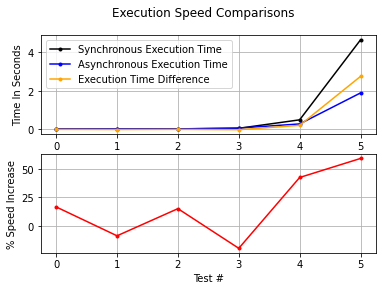

In [30]:
if __name__ == "__main__":  
    await main()